In [1]:
from pyvi.pyvi import ViTokenizer, ViPosTagger
from sklearn.base import TransformerMixin, BaseEstimator
import os
from sklearn.svm import LinearSVC
from gensim import corpora, matutils
from sklearn.metrics import classification_report
import sys
import codecs
import json
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DIR_PATH="/Users/mac/Downloads/Data"
DIR_PATH_TRAIN = os.path.join(DIR_PATH,'Train_Full')
DIR_PATH_TEST = os.path.join(DIR_PATH,'Test_Full')
DICTIONARY_PATH = os.path.join(DIR_PATH,'dictionary.txt')
STOP_WORDS = os.path.join(DIR_PATH,'stopwords-nlp-vi.txt')
SPECIAL_CHARACTER = '0123456789?…“”–%@$.,=+-!;/()*"&^:#|\n\t\''
print(STOP_WORDS)
label=['Van hoa','The gioi','Khoa hoc','Suc khoe','Chinh tri Xa hoi',
       'Vi tinh','Kinh doanh','The thao','Phap luat','Doi song']

/Users/mac/Downloads/Data/stopwords-nlp-vi.txt


In [3]:
class ReadData(object):
    def __init__(self,dataPath,encoder=None):
        self.dataPath = dataPath
        self.encoder = encoder if encoder != None else 'utf-16le'
        
    def get_name_files(self):
        class_file = os.listdir(self.dataPath)        
        class_label=[]
        folders=[]
        for file in os.listdir(self.dataPath):
            class_label.append(file)
            folders.append(os.path.join(self.dataPath,file))
        self.folders = folders
        self.class_label=class_label
        #print(self.class_label)
        #print (self.folders)
        
    def get_data(self):
        self.get_name_files()
        data=[]
        i=0
        for label in self.class_label:
            rand = random.randint(100,150)
            print(label)
            for file in os.listdir(self.folders[self.class_label.index(label)]):
                #print(file)
                i+=1
                with open(os.path.join(self.folders[self.class_label.index(label)],file),'rb') as f:
                    s = f.read()                  
                data.append({
                    "label":label,
                    "content":s.decode(self.encoder) 
                })
                if(i==rand): break
            i=0
            #if(i>100): break
        self.data=data
        print(len(data))
        return data
    
    def read_stopwords(self):
        with open(self.dataPath, 'r',encoding="utf-8") as f:
            stopwords = set([w.strip().replace(' ', '_') for w in f.readlines()])
        return stopwords
    
    def load_dictionary(self):
        return corpora.Dictionary.load_from_text(self.dataPath)          

In [4]:
class FileStore(object):
    def __init__(self, filePath, data = None):
        self.filePath = filePath
        self.data = data

    def store_dictionary(self, dict_words):
        dictionary = corpora.Dictionary(dict_words)
        #dictionary.filter_extremes(no_below=1, no_above=0.1)
        dictionary.filter_extremes(no_below=20, no_above=0.3)
        dictionary.save_as_text(self.filePath)

    def save_model(self,W,train_loss,train_acc,valid_loss,valid_acc,lr,reg):
        temp = []
        temp.append(lr)
        temp.append(reg)
        np.save(self.filePath+"/W_SVM.npy",W);
        np.save(self.filePath+"/train_loss.npy",train_loss);
        np.save(self.filePath+"/train_acc.npy",train_acc);
        np.save(self.filePath+"/valid_loss.npy",valid_loss);
        np.save(self.filePath+"/valid_acc.npy",valid_acc);
        np.save(self.filePath+"/lr_reg.npy",temp);

In [5]:
class FeatureExtraction(object):
    def __init__(self, data):
        self.data = data

    def __build_dictionary(self):
        print ('Building dictionary')
        dict_words = []
        i = 0
        for text in self.data:
            i+=1
            #print ("Step {} / {}".format(i, len(self.data)))
            words = NLP(text=text['content']).get_words_feature()
            dict_words.append(words)
        FileStore(filePath=DICTIONARY_PATH).store_dictionary(dict_words)

    def __load_dictionary(self):
        if os.path.exists(DICTIONARY_PATH) == False:
            self.__build_dictionary()
        self.dictionary = ReadData(DICTIONARY_PATH).load_dictionary()

    def build_dataset(self):
        self.features = []
        self.labels = []
        i = 0
        for d in self.data:
            i += 1
            #print ("Step {} / {}".format(i, len(self.data)))
            self.features.append(self.get_dense(d['content']))
            self.labels.append(label.index(d['label']))
            #self.labels.append(d['label'])

    def get_dense(self, text):
        self.__load_dictionary()
        words = NLP(text).get_words_feature()
        i=0
        #print(words)
        # Bag of words
        vec = self.dictionary.doc2bow(words)
        dense = list(matutils.corpus2dense([vec], num_terms=len(self.dictionary)).T[0])
        #return words,len(self.dictionary)
        return dense

    def get_data_and_label(self):
        self.build_dataset()
        return self.features, self.labels

In [6]:
class NLP(object):
    def __init__(self, text = None):
        self.text = text
        self.__set_stopwords()

    def segmentation(self):
        return ViTokenizer.tokenize(self.text)
    
    def display(self):
        print(self.segmentation())
        
    def __set_stopwords(self):
        self.stopwords = ReadData(STOP_WORDS).read_stopwords()
        
    def split_words(self):
        text = self.segmentation()
        try:
            return [x.strip(SPECIAL_CHARACTER).lower() for x in text.split()]
        except TypeError:
            return []
        
    def get_words_feature(self):
        split_words = self.split_words()
        return [word for word in split_words if word.encode('utf-8') not in self.stopwords]

In [8]:
read_train = ReadData(DIR_PATH_TRAIN)
data_train = read_train.get_data()
read_test = ReadData(DIR_PATH_TEST)
data_test = read_test.get_data()
x_train,y_train = FeatureExtraction(data=data_train).get_data_and_label()
x_test,y_test = FeatureExtraction(data=data_test).get_data_and_label()

Van hoa
The gioi
Khoa hoc
Suc khoe
Chinh tri Xa hoi
Vi tinh
Kinh doanh
The thao
Phap luat
Doi song
1295
Van hoa
The gioi
Khoa hoc
Suc khoe
Chinh tri Xa hoi
Vi tinh
Kinh doanh
The thao
Phap luat
Doi song
1293
Building dictionary


In [9]:
y_train = np.asarray(y_train)
onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train = onehot_encoder.fit_transform(y_train)
print(y_train.shape)

y_test = np.asarray(y_test)
onehot_encoder = OneHotEncoder(sparse=False)
y_test = y_test.reshape(len(y_test), 1)
y_test = onehot_encoder.fit_transform(y_test)
print(y_test.shape)

(1295, 10)
(1293, 10)


In [10]:
x_train = np.asarray(x_train)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test=np.asarray(x_test)
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])
print(x_train.shape)
print(x_test.shape)

(1295, 1818)
(1293, 1818)


In [11]:
train_numbers = np.random.choice(x_train.shape[0],round(x_train.shape[0]*0.8),replace=False)
valid_numbers = np.array(list(set(range(x_train.shape[0])) - set(train_numbers)))
print(train_numbers.shape)
print(valid_numbers.shape)

x_valid = x_train[valid_numbers]
x_train= x_train[train_numbers]
y_valid = y_train[valid_numbers]
y_train = y_train[train_numbers]

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1036,)
(259,)
(1036, 1818)
(259, 1818)
(1036, 10)
(259, 10)


In [24]:
sess = tf.Session()
delta = 1.0
regulation_rate = tf.placeholder(dtype=tf.float32,name="reg")
learning_rate = tf.placeholder(dtype=tf.float32,name="learn")

x_data = tf.placeholder(shape=[None,x_train.shape[1]], dtype=tf.float32,name='x_data')
y_data = tf.placeholder(shape=[None,y_train.shape[1]], dtype=tf.float32,name='y_data')    
W = tf.Variable(tf.random_normal(shape=[x_train.shape[1], y_train.shape[1]]),name='W_data')
    
predict = tf.matmul(x_data,W)
y = tf.reduce_sum(predict*y_data, 1, keep_dims=True)
loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, delta - y + predict),1))
loss = tf.add(loss,regulation_rate * tf.nn.l2_loss(W))

prediction = tf.argmax(predict,1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_data,1)), tf.float32))

# Declare optimizer
my_opt = tf.train.AdamOptimizer(learning_rate)
train_step = my_opt.minimize(loss)

# Initialize variables
# init = tf.global_variables_initializer()
# sess.run(init)

In [25]:
batch_size = 30
# learning_rates = [0.001,0.0015,0.002]
# regularization_strengths = [1e-9,1e-8,1e-7]
learning_rates = [0.001,0.0015]
regularization_strengths = [1e-9,1e-8]
loss_best=1000
epoch=81
for lr in learning_rates:
    for reg in regularization_strengths:     
        sess.run(tf.initialize_all_variables())
        train_loss = []
        valid_loss = []
        train_accuracy = []
        valid_accuracy = [] 
        for it in range(epoch): 
            mix_ids = np.random.permutation(x_train.shape[0])
            n_batches = int (np.ceil(x_train.shape[0]/float(batch_size)))
            for ib in range(n_batches):
                rand_index = mix_ids[batch_size*ib:min(batch_size*(ib+1),x_train.shape[0])]
                rand_x = x_train[rand_index]
                rand_y = y_train[rand_index,:]
                sess.run(train_step, feed_dict={x_data: rand_x, y_data: rand_y,learning_rate:lr,regulation_rate:reg})

                tloss = sess.run(loss, feed_dict={x_data: rand_x, y_data: rand_y,regulation_rate:reg})
                train_loss.append(tloss)   
    
                train_acc_temp = sess.run(accuracy, feed_dict={
                    x_data: x_train,
                    y_data: y_train})
                train_accuracy.append(train_acc_temp)   
            
                vloss = sess.run(loss, feed_dict={x_data: x_valid, y_data: y_valid,regulation_rate:reg})
                valid_loss.append(vloss)
    
                valid_acc_temp = sess.run(accuracy, feed_dict={
                    x_data: x_valid,
                    y_data: y_valid})
                valid_accuracy.append(valid_acc_temp) 
            if ((it) % 10 == 0):
                    print('epoch: '+str(it)+ ' - Loss_train: '+ str(tloss) +' - Acc_train: ' 
                      + str(train_acc_temp)+' - Loss_valid: '+str(vloss) + ' - Acc_valid: '+str(valid_acc_temp))
        print ("Learning_rate: "+str(lr) + " - Regulariation: "+ str(reg) + " - Train_loss: "+
               str(train_loss[-1]) +"- Valid_loss: "+ str(valid_loss[-1])+"\n")
        if (valid_loss[-1] < loss_best):
            loss_best = valid_loss[-1]
            W_best = sess.run(W)
            lr_best = lr
            reg_best = reg
            train_loss_best = train_loss
            valid_loss_best = valid_loss
            train_accuracy_best = train_accuracy
            valid_accuracy_best = valid_accuracy

i: 0 - Loss_train: 92.45016 - Acc_train: 0.08976834 - Loss_valid: 121.709625 - Acc_valid: 0.07335907
i: 10 - Loss_train: 17.912195 - Acc_train: 0.21718147 - Loss_valid: 66.138695 - Acc_valid: 0.16216215
i: 20 - Loss_train: 18.428852 - Acc_train: 0.36679536 - Loss_valid: 45.119644 - Acc_valid: 0.26640928
i: 30 - Loss_train: 19.28542 - Acc_train: 0.4903475 - Loss_valid: 35.024296 - Acc_valid: 0.37451738
i: 40 - Loss_train: 16.650112 - Acc_train: 0.5984556 - Loss_valid: 29.619839 - Acc_valid: 0.4092664
i: 50 - Loss_train: 5.174639 - Acc_train: 0.67084944 - Loss_valid: 26.423368 - Acc_valid: 0.44401544
i: 60 - Loss_train: 2.6319854 - Acc_train: 0.73455596 - Loss_valid: 24.321512 - Acc_valid: 0.48262548
i: 70 - Loss_train: 2.3547485 - Acc_train: 0.79633206 - Loss_valid: 23.03899 - Acc_valid: 0.5057915
i: 80 - Loss_train: 3.3030982 - Acc_train: 0.8368726 - Loss_valid: 22.016674 - Acc_valid: 0.5057915
Learning_rate: 0.001 - Regulariation: 1e-09 - Train_loss: 3.3030982- Valid_loss: 22.016674



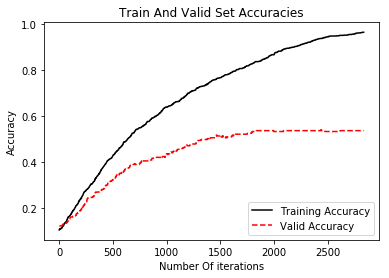

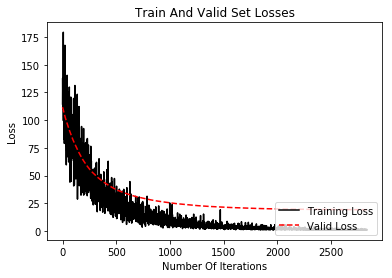

learning_rate:0.0015 regulation: 1e-09


In [29]:
plt.plot(train_accuracy_best, 'k-', label='Training Accuracy')
plt.plot(valid_accuracy_best, 'r--', label='Valid Accuracy')
plt.title('Train And Valid Set Accuracies')
plt.xlabel('Number Of iterations')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(train_loss_best, 'k-',label='Training Loss')
plt.plot(valid_loss_best, 'r--', label='Valid Loss')
plt.title('Train And Valid Set Losses')
plt.xlabel('Number Of Iterations')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
print("learning_rate:"+str(lr_best),"regulation: "+str(reg_best))

In [30]:
def test(x_data,y_data,W):
    y_pred = x_data.dot(W)
    acc = np.mean(np.argmax(y_pred,1) == np.argmax(y_data,1))
    return acc*100;
accuracy=test(x_test,y_test,W_best)
print(accuracy)

save_model = FileStore(filePath=DIR_PATH).save_model(W_best,train_loss_best,
                                                     train_accuracy_best,valid_loss_best,valid_accuracy_best,lr_best,reg_best)

SyntaxError: unexpected EOF while parsing (<ipython-input-30-01195e982052>, line 9)

In [32]:
temp1= np.load(DIR_PATH+"/train_loss.npy")
temp2= np.load(DIR_PATH+"/train_acc.npy")
temp3= np.load(DIR_PATH+"/valid_loss.npy")
temp4= np.load(DIR_PATH+"/valid_acc.npy")
temp5= np.load(DIR_PATH+"/lr_reg.npy")

In [33]:
temp1 = temp1.tolist()
temp2 = temp2.tolist()
temp3 = temp3.tolist()
temp4 = temp4.tolist()
temp5 = temp5.tolist()

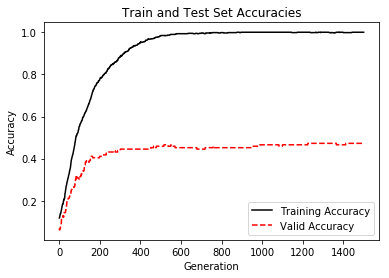

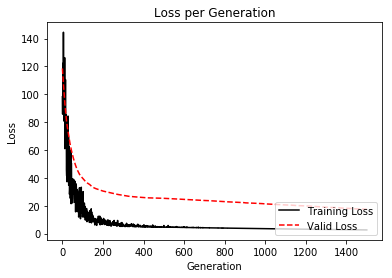

learning_rate:0.01 regulation: 0.0008


In [34]:
plt.plot(temp2, 'k-', label='Training Accuracy')
plt.plot(temp4, 'r--', label='Valid Accuracy')
plt.title('Train And Valid Set Accuracies')
plt.xlabel('Number Of iterations')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(temp1, 'k-',label='Training Loss')
plt.plot(temp3, 'r--', label='Valid Loss')
plt.title('Train And Valid Set Losses')
plt.xlabel('Number Of Iterations')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

print("learning_rate:"+str(temp5[0]),"regulation: "+str(temp5[1]))

In [ ]:
import codecs
from gensim import corpora, matutils
from pyvi.pyvi import ViTokenizer

import tkinter as tk
#from tkinter import ttk

from tkinter import *
from tkinter import filedialog
from tkinter.ttk import Frame, Button, Label, Style
from tkinter import messagebox

import re
#import pickle as cPickle
import numpy as np

LARGE_FONT = ("Verdana", 12)

class FileReader(object):
	def __init__(self, filePath, encoder = None):
		self.filePath = filePath
		self.encoder = encoder if encoder != None else 'utf-16le'

	def read(self):
		try:
			with codecs.open(self.filePath, "r", "utf-8") as f:
				s = f.read()
		except Exception:
			with codecs.open(self.filePath, "r", self.encoder) as f:
				s = f.read()
		return s
	def read_stopwords(self):
		with open(self.filePath, 'r', encoding="utf-8") as f:
			stopwords = set([w.strip().replace(' ', '_') for w in f.readlines()])
		return stopwords

	def load_dictionary(self):
		return corpora.Dictionary.load_from_text(self.filePath)

class NLP(object):
	def __init__(self, text = None):
		self.text = text
		self.__set_stopwords()

	def __set_stopwords(self):
		self.stopwords = FileReader('stopwords-nlp-vi.txt').read_stopwords()

	def segmentation(self):
		return ViTokenizer.tokenize(self.text)

	def split_words(self):
		text = self.segmentation()
		try:
			return [x.strip('01234”56789%@$.,“?=+-!;/()–*’…"&^:#|\n\t\'').lower() for x in text.split()]
		except TypeError:
			return []

	def get_words_feature(self):
		split_words = self.split_words()
		return [word for word in split_words if word.encode('utf-8') not in self.stopwords]

class FeatureExtraction(object):
	def __load_dictionary(self):
		self.dictionary = FileReader('dictionary/dictionary.txt').load_dictionary()

	def get_dense(self, text):
		self.__load_dictionary()
		words = NLP(text).get_words_feature()
		vec = self.dictionary.doc2bow(words)
		dense = list(matutils.corpus2dense([vec], num_terms=len(self.dictionary)).T[0])
		return dense

class Window(Frame):
	def __init__(self, parent = None):
		Frame.__init__(self, parent)
		self.parent = parent
		self.path_file = None
		self.text_predict = None
		self.init_window()
		#with open('trained_model/my_dumped_classifier.pkl', 'rb') as fid:
		#	model = cPickle.load(fid)
		#self.model = model
		self.W_best = np.load('weight/weight.npy')
		self.label = ['Văn hóa', 'Thế giới', 'Khoa học', 'Sức khỏe', 'Chính trị xã hội',
		'Vi tính', 'Kinh doanh', 'Thể thao', 'Pháp luật', 'Đời sống']

	def init_window(self):
		self.parent.title("Classfication")

		self.style = Style()
		self.style.theme_use("clam")

		self.pack(fill = BOTH, expand = 1)

		quitButton = Button(self, text = 'Quit', command = self.close_window)
		#quitButton.config(font = BUTTON_FONT)
		quitButton.place(x = 0, y = 0)

		labelBrowse = Label(self, text = 'Chọn file .txt dự đoán: ', font = LARGE_FONT)
		labelBrowse.place(x = 50, y = 50)

		browseButton = Button(self, text = 'Browse file', command = self.browse_file)
		browseButton.place(x = 240, y = 45)

		self.text = Label(self, text = self.path_file, font = LARGE_FONT)
		self.text.place(x = 340, y = 50)

		predictButton = Button(self, text = 'Predict', command = self.predict)
		predictButton.place(x = 240, y = 80)

		self.textBox = Text(self, height = 24, width = 94, font = LARGE_FONT)
		scroll = Scrollbar(self)
		#scroll.pack(side = RIGHT, fill = Y)
		#self.textBox.pack(side = LEFT, fill = Y)
		scroll.config(command = self.textBox.yview)
		#self.textBox.config(yscrollcommand = scroll.set)
		#test = "affffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff"
		#self.textBox.insert(END, test)
		self.textBox.place(x = 80, y = 120)
		self.textBox.config(state = DISABLED)

		self.predictLabel = Label(self, text = self.text_predict, font = LARGE_FONT)
		self.predictLabel.place(x = 340, y = 87)

	def close_window(self):
		click = messagebox.askquestion("Close Window", "Are You Sure?", icon = 'warning')
		if click == 'yes':
			exit()

	def browse_file(self):
		filename = filedialog.askopenfilename()
		self.path_file = filename
		self.text.config(text = filename)

		isTxt = re.findall(r"\.\w{1,}", filename)
		if len(isTxt) == 0:
			messagebox.showinfo(title = "Error", message = "Lỗi định dạng file")
			self.textBox.config(state = NORMAL)
			self.textBox.delete('1.0', END)
			self.textBox.config(state = DISABLED)
			self.content = "";
		else:
			if isTxt[0] == ".txt":
				txt = FileReader(filename).read()
				self.textBox.config(state = NORMAL)
				self.textBox.delete('1.0', END)
				self.textBox.insert(END, txt)
				self.textBox.config(state = DISABLED)
				self.content = txt;
				#messagebox.showinfo(title = "Infomation", message = txt)
			else:
				messagebox.showinfo(title = "Error", message = "Lỗi định dạng file")
				self.textBox.config(state = NORMAL)
				self.textBox.delete('1.0', END)
				self.textBox.config(state = DISABLED)
				self.content = "";
		#messagebox.showinfo(title = 'Infomation', message = filename)

	def predict(self):
		if self.content != "":
			self.dense = FeatureExtraction().get_dense(self.content)
			#vector = np.reshape(self.dense, (-1, 1)).T
			#label_predict = self.model.predict(vector)
			#self.predictLabel.config(text = label_predict[0])
			x_predict = np.asarray(self.dense)
			x_predict = np.hstack([x_predict, 1])
			y_predict = x_predict.dot(self.W_best)
			index_predict = np.argmax(y_predict)
			self.predictLabel.config(text = self.label[index_predict])
		else:
			self.predictLabel.config(text = "")
			messagebox.showinfo(title = "Error", message = "Vui lòng chọn file")

def disable_event():
	pass

root = Tk()
root.geometry("1100x600+130+50")
root.protocol("WM_DELETE_WINDOW", disable_event)
root.resizable(0, 0)
app = Window(root)
root.mainloop()

In [ ]:
saver = tf.train.Saver()
sess.run(W)
saver.save(sess,"/Users/mac/Downloads/Data/svm_model",global_step=100)

In [ ]:
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('/Users/mac/Downloads/Data/svm_model-100.meta')
saver.restore(sess,tf.train.latest_checkpoint('/Users/mac/Downloads/Data/'))

# Access saved Variables directly
print(sess.run('reg'))
print(sess.run('learn'))
# This will print 2, which is the value of bias that we saved

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()
x = graph.get_tensor_by_name("x_data")
y = graph.get_tensor_by_name("y_data")
feed_dict ={x:x_test,y:y_test}

#Now, access the op that you want to run. 
op_to_restore = graph.get_tensor_by_name("op_to_restore:0")

print (sess.run(op_to_restore,feed_dict))

In [18]:
X = np.random.rand(50,100)
Y = np.random.rand(50,10)
batchsize=6
numiters = 10
for it in range(numiters):
    mixids = np.random.permutation(X.shape[0])
    print(mixids)
    nbatches = int (np.ceil(X.shape[0]/float(batchsize)))
    print(nbatches)
    for ib in range(nbatches):
        ids = mixids[batchsize*ib:min(batchsize*(ib+1),X.shape[0])]
        print(ids)


[49 32  5 42 12 45 28 39 23 30 26 10 15 21 47 19 13  8 41 11 31 29  2 46
 20  9 36 40 22 43 25 17  1 44 48 33 35 18 24  4  6 38  0 27  7 37 34  3
 14 16]
9
[49 32  5 42 12 45]
[28 39 23 30 26 10]
[15 21 47 19 13  8]
[41 11 31 29  2 46]
[20  9 36 40 22 43]
[25 17  1 44 48 33]
[35 18 24  4  6 38]
[ 0 27  7 37 34  3]
[14 16]
[19 20  6 45 13 10 41 23 37 28 21  0  7 12 39 17 40 44 14  5  4  2 25 36
 46  1 11 30 27 24 48 35 33 18 42 22  3 38  8 26 15  9 43 29 16 34 32 31
 47 49]
9
[19 20  6 45 13 10]
[41 23 37 28 21  0]
[ 7 12 39 17 40 44]
[14  5  4  2 25 36]
[46  1 11 30 27 24]
[48 35 33 18 42 22]
[ 3 38  8 26 15  9]
[43 29 16 34 32 31]
[47 49]
[38  0 14 21  3 44 12  4 40 36 22 33 19 39 25  6 20 43 28 34 10 42 41  8
 17 47 13 49 26 30 32 23 11 29  9 27 16 45 46 18  2 37  5  1 15 48 31 24
 35  7]
9
[38  0 14 21  3 44]
[12  4 40 36 22 33]
[19 39 25  6 20 43]
[28 34 10 42 41  8]
[17 47 13 49 26 30]
[32 23 11 29  9 27]
[16 45 46 18  2 37]
[ 5  1 15 48 31 24]
[35  7]
[41 15 40 38 18 37 13 44 48 

In [ ]:
sess = tf.Session()
#feature_size = x_train.shape[1]
delta = 1.0
regulation_rate = 8e-4
x_data = tf.placeholder(shape=[None,x_train.shape[1]], dtype=tf.float32)
y_data = tf.placeholder(shape=[None,y_train.shape[1]], dtype=tf.float32)
W = tf.Variable(tf.random_normal(shape=[x_train.shape[1], y_train.shape[1]]))

def svm_loss(x_data,y_data,W,regulation_rate):
    # graph = tf.Graph()
    # with graph.as_default():
    predict = tf.matmul(x_data,W)
    y = tf.reduce_sum(predict*y_data, 1, keep_dims=True)
    #loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, delta - y + predict),1))-delta
    loss = tf.reduce_mean(tf.reduce_sum(tf.maximum(0.0, delta - y + predict),1))
    loss = tf.add(loss,regulation_rate * tf.nn.l2_loss(W))
 
    return loss

def accuracy(x_data,y_data,W):
    predict = tf.matmul(x_data,W)
    prediction = tf.argmax(predict,1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_data,1)), tf.float32))
    return accuracy*100;

def svm_multi_class(x_data,y_data,Winit,reg,lr=8e-4,batch_size = 100, num_iters = 1500):
    W = Winit
    my_opt = tf.train.AdamOptimizer(lr)
    train_step = my_opt.minimize(loss)
    for i in range(num_iters):
        rand_index = np.random.choice(x_data.shape[0], size=batch_size)
        rand_x = x_data[rand_index]
        rand_y = y_data[rand_index,:]
        sess.run(train_step, feed_dict={x_data: rand_x, y_data: rand_y})

        tloss = sess.run(svm_loss, feed_dict={x_data: rand_x, y_data: rand_y,regulation_rate=lr})
        train_loss.append(tloss)

        Weight = sess.run(W)
        vloss = sess.run(loss, feed_dict={x_data: x_valid, y_data: y_valid,W:Weight})
        valid_loss.append(vloss)
    
        train_acc_temp = sess.run(accuracy, feed_dict={
            x_data: x_train,
            y_data: y_train})
        train_accuracy.append(train_acc_temp)

        valid_acc_temp = sess.run(accuracy, feed_dict={
            x_data: x_valid,
            y_data: y_valid})
        valid_accuracy.append(valid_acc_temp)
    return W,train_loss,train_accuracy,valid_loss,valid_accuracy    
    
